# Facial Attributes Classifier Models

In this file I classify images of specific facial att. and will use **transfer learning** to improve results.

**Note:** It is recommended to run this file on **Google Colab** with GPU acceleration. 


### This file contain functions for: 
- Data Preparation
    * preprocess image
    * split train test for
        * Positive Class - 1
        * Negative Class - 0
    * Create Labeled DF for train and test (file_id, label, image)
    
- Apply ImageDataGenerator class
    * Train Set
    * Validation Set
    * Test Set
    
- Modeling using DeepFace assemble or standalone of: 
    
    * 'vgg_face': VGGFace,
    * 'open_face': OpenFace,
    * 'facenet': Facenet,
    * 'deep_face': FbDeepFace,
    * 'deep_id': DeepID,
    * "emotion": Emotion,
    * "age": Age,
    * "gender": Gender,
    * "race": Race
      
    - Transfer Learning with:
        * Callback
        * Optimzing
        * Fitting
        * Predicting

### Imports

In [202]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from varname import nameof
import shutil 
import cv2
import os
import sys
import json
from google.colab import drive

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
np.set_printoptions(precision=2)
# pd.options.display.max_seq_items = 20

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Input, Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import optimizers
import tensorboard
from sklearn.metrics import classification_report

#facial analysis
from deepface.extendedmodels import Age, Gender, Race, Emotion
from deepface.basemodels import VGGFace, OpenFace, Facenet, FbDeepFace, DeepID
from deepface import DeepFace

### Constant path for Colab or Local

In [2]:
def find_imagepath(file):
    """
    function look for image files in the relevant directory determine by condiotion
    param: file - str name of image file
    return: relevent file path
    """
    temp_file = int(file.split('.')[0][-6:])
    if temp_file <= 70000:
        IMAGEPATH = 'Datasets/face_att/1/'
    elif temp_file > 70000 and temp_file < 140000:
        IMAGEPATH = 'Datasets/face_att/2/'
    elif temp_file >= 140000:
        IMAGEPATH = 'Datasets/face_att/3/'
    else:
        IMAGEPATH = 'Datasets/face_att/'
    return os.path.join(IMAGEPATH, file)

In [3]:
if os.getcwd() != '/content':
    IMAGEPATH = 'Datasets'
    IND_FILE = 'files list.csv'
    try:
        FACEPATH = os.path.join(IMAGEPATH,'face_att')
    except:
        FACEPATH = find_imagepath(file)
else:
    drive.mount('/content/drive')
    IND_FILE = '/content/drive/My Drive/Cellebrite/files list.csv'
    IMAGEPATH = '/content/drive/My Drive/Cellebrite/Datasets'
    FACEPATH = os.path.join(IMAGEPATH,'face_att')

# Data Preparation
Data splited to sets for each label

In [74]:
def img_preprocess(data, img_size):
    data_img = []
    
    # Images Preprocess
    IMG_WIDTH = img_size
    IMG_HEIGHT = img_size
    
    for i in data.iloc[:,0]:
        file_path = find_imagepath(i)
        image = cv2.imread(file_path)
        image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.cv2.CAP_OPENNI_GRAY_IMAGE)
        image = np.array(image).astype('float32')/255. 
        data_img.append(image)
    return data_img

In [136]:
def data_preprocess(index_file, labels='Eyeglasses', balance=5000, binary=True, img_size=224):
    """
    function read "files list.csv" and return train test filename and pixel represtation for the called label
    params: index_file - CSV for indexed labels
            labels - list of labels from csv columns name
            balance - int for a specific balanced set size
            binary - bool if user want also the negative class (= 0_  +  labels)
    returns: balanced train test set for positive and negative or multiclass labels        
    """
    
    # read labels file list
    df_label = pd.read_csv(index_file, usecols=[labels])
    
       
    # Get the label folder if not provide or label files are mix in the same folder
#     folder = df_label[labels].apply(lambda x: '_'.join(str(x).split('_')[:-1])).unique()
#     folder = [f for f in folder if f]
    
    # Train Test Split
    if balance == None:
        train_size = int(len(df_label)*0.8)
    else:
        train_size = int(balance*0.8) #int(input('Please enter 2nd class train size: '))
        
    train = df_label[:train_size]
    test = df_label[train_size:balance]
    
    print(f"Starting Image Preprocessing")    
    # Preprocess train image
    train_img = img_preprocess(train, img_size)
    class_label =[np.zeros(len(train)) if labels[0].isdigit() else np.ones(len(train))]
    train = pd.DataFrame({'files': train.iloc[:,0], 'label': np.array(*class_label).astype(str), 'image': pd.Series(train_img)})
   
    # Preprocess test image
    test_img = img_preprocess(test, img_size)
    class_label = [np.zeros(len(test)) if labels[0].isdigit() else np.ones(len(test))]
    test = pd.DataFrame({'files': test.iloc[:,0], 'label': np.array(*class_label).astype(str), 'image': test_img})
    print('Done!')
    
    if binary:
        print('Creating Negative Class')
        # check for balanced data
        assert pd.read_csv(index_file, usecols=['0_'+labels]).shape[0] == df_label[labels].shape[0]
     
        # Add Negative class
        train_n, test_n = data_preprocess(IND_FILE, '0_'+labels, binary=False)
        train = pd.concat([train, train_n], axis=0)
        test = pd.concat([test, test_n], axis=0)
        print('Shape with Negative class:')
    
    print(f'Train shape: \t{np.array(train).shape}\nTest shape: \t{np.array(test).shape}')

    return train, test

In [137]:
train, test = data_preprocess(IND_FILE, 'Eyeglasses')
test.head()

Starting Image Preprocessing
Done!
Creating Negative Class
Starting Image Preprocessing
Done!
Train shape: 	(4000, 3)
Test shape: 	(1000, 3)
Shape with Negative class:
Train shape: 	(8000, 3)
Test shape: 	(2000, 3)


,files,label,image
4000,face_att_061429.jpg,1.0,"[[0.14117648, 0.10980392, 0.09411765, 0.098039..."
4001,face_att_061443.jpg,1.0,"[[0.27058825, 0.25882354, 0.24705882, 0.231372..."
4002,face_att_061457.jpg,1.0,"[[0.46666667, 0.46666667, 0.46666667, 0.466666..."
4003,face_att_061459.jpg,1.0,"[[0.9843137, 0.9843137, 0.9843137, 0.9843137, ..."
4004,face_att_061467.jpg,1.0,"[[0.22745098, 0.22745098, 0.22745098, 0.227450..."


### Sanity Check 

In [199]:
labels = [test['files'][test['label']=='1.0'], test['files'][test['label']=='0.0']]
titles = ['Glasses', 'W/O Glasses']

for l, j, t in zip(labels, range(1,3), titles):
    plt.figure(figsize=(20,10))
    for i in range(5):
        file = l.iloc[np.random.choice(len(l)),0]
        file_path = find_imagepath(file)
        img = mpimg.imread(file_path)
        ax = plt.subplot(2, 5, i+1)
        plt.suptitle(t)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

IndexingError: Too many indexers

<Figure size 1440x720 with 0 Axes>

#### `ImageDataGenerator` class 
load our dataset as an iterator (not keeping it all in memory at once).

In [146]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [149]:
train['label'] = train['label'].astype(str)

In [150]:
img_gen = ImageDataGenerator(validation_split=0.2)

### Train Set

In [151]:
train_data = img_gen.flow_from_dataframe(train,
                                         directory=FACEPATH+'/1/',
                                         x_col='files', 
                                         y_col='label', 
                                         class_mode='binary', 
                                         batch_size=64, 
                                         target_size=(224, 224), 
                                         subset='training')

Found 6400 validated image filenames belonging to 2 classes.


### Validation Set

In [152]:
valid_data = img_gen.flow_from_dataframe(train,
                                         directory=FACEPATH+'/1/',
                                         x_col='files', 
                                         y_col='label', 
                                         class_mode='binary', 
                                         batch_size=64, 
                                         target_size=(224, 224), 
                                         subset='validation')

Found 1600 validated image filenames belonging to 2 classes.


### Test Set

In [153]:
img_gen_test = ImageDataGenerator()
test_data = img_gen_test.flow_from_dataframe(test,
                                        directory=FACEPATH+'/1/',
                                        x_col='files', 
                                        y_col='label',
                                        class_mode=None, 
                                        target_size=(224,224), 
                                        batch_size=64, 
                                        shuffle=False)

Found 1561 validated image filenames.


# Modeling

### Load FaceDetection Models

In [209]:
def load_model(model):
    """
    load face detection models
    """
    models = {'vgg_face': VGGFace,
              'open_face': OpenFace,
              'facenet': Facenet,
              'deep_face': FbDeepFace,
              'deep_id': DeepID,
              "emotion": Emotion,
              "age": Age,
              "gender": Gender,
              "race": Race}
    
    return models[model].loadModel()

In [237]:
def print_summary(model):
    print(f"Input_shape:\t{model.input_shape}\nOutput_shape:\t{model.output_shape}\nParams:\t{model.count_params()} \
    \nLayers:\t{len(model.layers)}\n\n")
    return model.summary()

### Vgg16

In [238]:
# By default, it loads weights pre-trained on ImageNet. 
vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224,224,3))

In [239]:
print_summary(vgg16)

Input_shape:	(None, 224, 224, 3)
Output_shape:	(None, 7, 7, 512)
Params:	14714688     
Layers:	19


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________

In [240]:
#                         Top Layers Removed:
# flatten (Flatten)            (None, 25088)             0         
# _________________________________________________________________
# fc1 (Dense)                  (None, 4096)              102764544 
# _________________________________________________________________
# fc2 (Dense)                  (None, 4096)              16781312  
# _________________________________________________________________
# predictions (Dense)          (None, 1000)              4097000

### Facenet

In [241]:
facenet = load_model('facenet')
print_summary(facenet)

Input_shape:	(None, 160, 160, 3)
Output_shape:	(None, 128)
Params:	22808144     
Layers:	447


Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_26[0][0]                   
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_Batch

### VggFace

In [242]:
vggface = load_model('vgg_face')
print_summary(vggface)

Input_shape:	(None, 224, 224, 3)
Output_shape:	(None, 2622)
Params:	145002878     
Layers:	38


Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_52_input (Inp [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_52 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_53 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 64)      0         
________________________

### DeepID

In [193]:
# deep_id = load_model('deep_id')
# print_summary(deep_id)

## Transfer Learning

Adding new model `model` whose first layer is `vggface/vgg_face` with additional layers 
(from `tensorflow.keras.layers`):

In [243]:
def adding_toplayers(base_model):
    """
    Function takes basemodel and add top layers
    """
    base_model.trainable=False
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    print_summary(model)
    return model

In [257]:
# classes = 2
# base_model_output = Sequential()
# base_model_output = Convolution2D(classes, (1, 1), name='predictions')(basemodel.layers[-4].output)
# base_model_output = Flatten()(base_model_output)
# base_model_output = Dense(128, activation='relu')(base_model_output)
# base_model_output = Dense(2, activation='relu')(base_model_output)
# base_model_output = Activation('relu')(base_model_output)
# model = Model(inputs=vggface.input, outputs=base_model_output)
# -----------------------------------------------------------
# model = Sequential()
# model.add(basemodel)
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# ------------------------------------------------------------
# model = Sequential()
# model = Convolution2D(classes, (1, 1), name='predictions')(basemodel.layers[-4].output)
# model = Flatten()(model)
# model = Activation('relu')(model)
# model = Flatten()(model)
# model = Convolution2D(64, 3, padding='same', input_shape=(32,32,3))(model)
# model = Activation('relu')(model)
# model = Convolution2D(64, (3, 3))(model)
# model = Activation('relu')(model)
# model = MaxPooling2D(pool_size=(2, 2))(model)
# model = Dropout(0.25)(model)
# model = Convolution2D(32, (3, 3), padding='same')(model)
# model = Activation('relu')(model)
# model = Convolution2D(32, (3, 3))(model)
# model = Activation('relu')(model)
# model = MaxPooling2D(pool_size=(2, 2))(model)
# model = Dropout(0.25)(model)
# model = Flatten()(model)
# model = Dense(512)(model)
# model = Activation('relu')(model)
# model = Dropout(0.5)(model)
# model = Dense(10, activation='relu')(model)

To train our transfer learning model we will freeze the weights of the basemodel and only train the added layers.

In [258]:
mod_vgg16 = adding_toplayers(vgg16)
mod_facenet = adding_toplayers(facenet)
mod_vggface = adding_toplayers(vggface)

Input_shape:	(None, 224, 224, 3)
Output_shape:	(None, 1)
Params:	17926209     
Layers:	4


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_20 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 129       
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________
Input_shape:	(None, 160, 160, 3)
Output_shape:	(None, 1)
Params:	22824785     
Layers:	4


Model: "sequential_21"
__________________________

In [259]:
models = [mod_vgg16, mod_vggface, mod_facenet]
model = mod_vgg16

In [277]:
# Callback
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callback_list = [earlystopper, checkpoint]

# Optimzing
model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss='binary_crossentropy', metrics=["accuracy"])

# Fitting
STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VALID=valid_data.n//valid_data.batch_size
STEP_SIZE_TEST=test_data.n//test_data.batch_size
EPOCH = 1

In [262]:
history = model.fit(train_data,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_data,
          validation_steps=STEP_SIZE_VALID,
          callbacks=callback_list,
          epochs=EPOCH)

100/100 [==============================] - ETA: 0s - loss: 1.1068 - accuracy: 0.8733 
Epoch 00001: val_loss improved from inf to 0.50939, saving model to model.h5
100/100 [==============================] - 2068s 21s/step - loss: 1.1068 - accuracy: 0.8733 - val_loss: 0.5094 - val_accuracy: 0.8813


In [264]:
loss, acc = model.evaluate(valid_data,steps=STEP_SIZE_TEST)

24/24 [==============================] - 252s 10s/step - loss: 0.5033 - accuracy: 0.8828


In [265]:
print(f"Loss:\t{round(loss,2)}\nAcc.:\t{round(acc,2)}")

Loss:	0.5
Acc.:	0.88


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

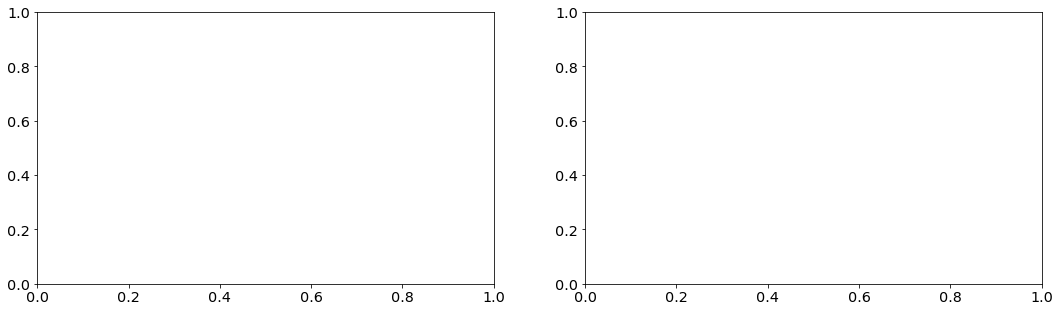

In [275]:
# plot the training loss and accuracy
# plt.style.use("ggplot")
fig, ax = plt.subplots(1, 2, figsize=(18,5))
ax.plot(np.arange(1, EPOCH), history.history["loss"], label="train")
plt.plot(np.arange(1, EPOCH), history.history["val_loss"], label="val")
plt.plot(np.arange(1, EPOCH), history.history["accuracy"], label="train")
plt.plot(np.arange(1, EPOCH), history.history["val_accuracy"], label="val")
plt.suptitle("Val & Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(loc="middle right")

In [101]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [102]:
# plot_confusion_matrix(cm, class_names)

NameError: name 'cm' is not defined

### Predicting

In [103]:
filenames_test = test_data.filenames

In [104]:
test_data.reset()
pred = model1.predict(test_data,
                     steps=STEP_SIZE_TEST,
                     verbose=1)

24/24 [==============================] - 250s 10s/step


In [ ]:
y_pred = list(map(lambda x: 1 if float(x) >= 0.2 else 0 , pred))# {1.0:'With',0.0:'W/O'}
pd.DataFrame(data=(filenames_test, y_pred, test_eyeglasses['files'], test_eyeglasses['label'])).T

In [ ]:
predicted_class_indices = np.argmax(pred, axis=1)
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
len(predictions)

In [ ]:
filenames=test_data.filenames
s = len(predictions)
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results['Predictions'].unique()

In [251]:
def analyze(img_path, actions = [], models = {}, enforce_detection = True, detector_backend = 'opencv'):

    if type(img_path) == list:
        img_paths = img_path.copy()
        bulkProcess = True
    else:
        img_paths = [img_path]
        bulkProcess = False

    #---------------------------------

    #if a specific target is not passed, then find them all
    if len(actions) == 0:
        actions= ['emotion', 'age', 'gender', 'race', 'eyeglass']

    #print("Actions to do: ", actions)

    #---------------------------------

    if 'emotion' in actions:
        if 'emotion' in models:
            print("already built emotion model is passed")
            emotion_model = models['emotion']
        else:
            emotion_model = Emotion.loadModel()

    if 'age' in actions:
        if 'age' in models:
            print("already built age model is passed")
            age_model = models['age']
        else:
            age_model = Age.loadModel()

    if 'gender' in actions:
        if 'gender' in models:
            print("already built gender model is passed")
            gender_model = models['gender']
        else:
            gender_model = Gender.loadModel()

    if 'race' in actions:
        if 'race' in models:
            print("already built race model is passed")
            race_model = models['race']
        else:
            race_model = Race.loadModel()
            
    if 'eyeglass' in actions:
        if 'eyeglass' in models:
            print("already built race model is passed")
            eyeglass_model = models['eyeglass']
        else:
            eyeglass_model = eyeglasses_model.loads('eyeglass.h5')
    #---------------------------------

    resp_objects = []

    disable_option = False if len(img_paths) > 1 else True

    global_pbar = tqdm(range(0,len(img_paths)), desc='Analyzing', disable = disable_option)

    #for img_path in img_paths:
    for j in global_pbar:
        img_path = img_paths[j]

        resp_obj = "{"

        disable_option = False if len(actions) > 1 else True

        pbar = tqdm(range(0,len(actions)), desc='Finding actions', disable = disable_option)

        action_idx = 0
        img_224 = None # Set to prevent re-detection
        #for action in actions:
        for index in pbar:
            action = actions[index]
            pbar.set_description("Action: %s" % (action))

            if action_idx > 0:
                resp_obj += ", "

            if action == 'emotion':
                emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
                img = functions.preprocess_face(img = img_path, target_size = (48, 48), grayscale = True, enforce_detection = enforce_detection, detector_backend = detector_backend)

                emotion_predictions = emotion_model.predict(img)[0,:]

                sum_of_predictions = emotion_predictions.sum()

                emotion_obj = "\"emotion\": {"
                for i in range(0, len(emotion_labels)):
                    emotion_label = emotion_labels[i]
                    emotion_prediction = 100 * emotion_predictions[i] / sum_of_predictions

                    if i > 0: emotion_obj += ", "

                    emotion_obj += "\"%s\": %s" % (emotion_label, emotion_prediction)

                emotion_obj += "}"

                emotion_obj += ", \"dominant_emotion\": \"%s\"" % (emotion_labels[np.argmax(emotion_predictions)])

                resp_obj += emotion_obj

            elif action == 'age':
                if img_224 is None:
                    img_224 = functions.preprocess_face(img_path, target_size = (224, 224), grayscale = False, enforce_detection = enforce_detection) #just emotion model expects grayscale images
                #print("age prediction")
                age_predictions = age_model.predict(img_224)[0,:]
                apparent_age = Age.findApparentAge(age_predictions)

                resp_obj += "\"age\": %s" % (apparent_age)

            elif action == 'gender':
                if img_224 is None:
                    img_224 = functions.preprocess_face(img = img_path, target_size = (224, 224), grayscale = False, enforce_detection = enforce_detection, detector_backend = detector_backend) #just emotion model expects grayscale images
                #print("gender prediction")

                gender_prediction = gender_model.predict(img_224)[0,:]

                if np.argmax(gender_prediction) == 0:
                    gender = "Woman"
                elif np.argmax(gender_prediction) == 1:
                    gender = "Man"
            
            elif action == 'eyeglass':
                if img_224 is None:
                    img_224 = functions.preprocess_face(img = img_path, target_size = (224, 224), grayscale = False, enforce_detection = enforce_detection, detector_backend = detector_backend) #just emotion model expects grayscale images
                #print("gender prediction")

                eyeglass_prediction = eyeglass_model.predict(img_224)[0,:]

                if np.argmax(eyeglass_prediction) == 0:
                    eg = "W/O Eyeglasses"
                elif np.argmax(eyeglass_prediction) == 1:
                    eg = "With Eyeglasses"


                resp_obj += "\"eyeglass\": \"%s\"" % (eg)

            elif action == 'race':
                if img_224 is None:
                    img_224 = functions.preprocess_face(img = img_path, target_size = (224, 224), grayscale = False, enforce_detection = enforce_detection, detector_backend = detector_backend) #just emotion model expects grayscale images
                race_predictions = race_model.predict(img_224)[0,:]
                race_labels = ['asian', 'indian', 'black', 'white', 'middle eastern', 'latino hispanic']

                sum_of_predictions = race_predictions.sum()

                race_obj = "\"race\": {"
                for i in range(0, len(race_labels)):
                    race_label = race_labels[i]
                    race_prediction = 100 * race_predictions[i] / sum_of_predictions

                    if i > 0: race_obj += ", "

                    race_obj += "\"%s\": %s" % (race_label, race_prediction)

                race_obj += "}"
                race_obj += ", \"dominant_race\": \"%s\"" % (race_labels[np.argmax(race_predictions)])

                resp_obj += race_obj

            action_idx = action_idx + 1

        resp_obj += "}"

        resp_obj = json.loads(resp_obj)

        if bulkProcess == True:
            resp_objects.append(resp_obj)
        else:
            return resp_obj

    if bulkProcess == True:
        resp_obj = "{"

        for i in range(0, len(resp_objects)):
            resp_item = json.dumps(resp_objects[i])

            if i > 0:
                resp_obj += ", "

            resp_obj += "\"instance_"+str(i+1)+"\": "+resp_item
        resp_obj += "}"
        resp_obj = json.loads(resp_obj)
        return resp_obj


In [259]:
def analyze_face(df, backend=0):
    """
    Function call image file as str or from dataframe and analyze it with deepface module to extract
    race, age, gender and emotion
    """
    
    # reading file
    if isinstance(df, str):
        file = find_imagepath(df)
    else:
        img_f1 = df.sample().values[0]
        file = find_imagepath(img_f1)
    
    # Run DeepFace
    try:
        backends = ['opencv', 'ssd', 'dlib', 'mtcnn']
        demography = DeepFace.analyze(file, detector_backend = backends[backend])
        age = int(demography['age'])
        gender = demography['gender']
        emotion = demography['dominant_emotion']
        race = demography['dominant_race']
        textstr = f'Age:\t\t{age}\nGender:\t\t{gender}\nRace:\t\t{race.title()}\nEmotion:\t{emotion.title()}'

    except ValueError: 
        print('Face could not be detected')
        sys.exit()
        
    # Plot
    plt.figure(figsize=(5,5))
    img = mpimg.imread(file)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print(textstr)
# DeepFace.verify("img1.jpg", "img2.jpg", model_name = "VGG-Face", model = model)

In [264]:
# eyeglass_model = tf.saved_model.load(os.path.join(os.getcwd(), 'eyeglass.h5'))
model.load('eyeglass.h5')

AttributeError: 'Sequential' object has no attribute 'load'




Finding actions:   0%|          | 0/4 [00:00<?, ?it/s]


Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]




Action: emotion:  25%|██▌       | 1/4 [00:00<00:02,  1.12it/s]


Action: age:  25%|██▌       | 1/4 [00:00<00:02,  1.12it/s]    




Action: age:  50%|█████     | 2/4 [00:03<00:02,  1.46s/it]


Action: gender:  50%|█████     | 2/4 [00:03<00:02,  1.46s/it]




Action: gender:  75%|███████▌  | 3/4 [00:05<00:01,  1.45s/it]


Action: race:  75%|███████▌  | 3/4 [00:05<00:01,  1.45s/it]  




Action: race: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


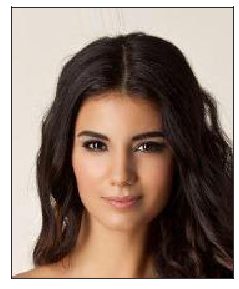

Age:		31
Gender:		Woman
Race:		White
Emotion:	Neutral


In [261]:
# padded_shapes = ([90000], ())
analyze_face(results['Filename'])

In [238]:
# DeepFace.stream(IMAGEPATH)